In [1]:
import math, os, time, numpy as np, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def seed_everything(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [2]:
def generate_data(data: str, batch_size: int = 200, device: str = "cpu") -> torch.Tensor:
    """
    Generate synthetic 2D datasets without rewards.

    Parameters
    ----------
    data : {"rings", "8gaussians", "2spirals", "checkerboard"}
    batch_size : int
    device : str

    Returns
    -------
    X : torch.FloatTensor of shape (batch_size, 2)
    """
    def torch_linspace_exclusive(start, stop, steps, device="cpu"):
        return torch.linspace(start, stop, steps + 1, device=device)[:-1]

    if data == "rings":
        # split into 4 rings
        n4 = n3 = n2 = batch_size // 4
        n1 = batch_size - n4 - n3 - n2

        angle4 = torch_linspace_exclusive(0, 2 * np.pi, n4, device=device)
        angle3 = torch_linspace_exclusive(0, 2 * np.pi, n3, device=device)
        angle2 = torch_linspace_exclusive(0, 2 * np.pi, n2, device=device)
        angle1 = torch_linspace_exclusive(0, 2 * np.pi, n1, device=device)

        circ4 = torch.stack([torch.cos(angle4), torch.sin(angle4)], dim=1)         # r = 1.00
        circ3 = torch.stack([torch.cos(angle3), torch.sin(angle3)], dim=1) * 0.75  # r = 0.75
        circ2 = torch.stack([torch.cos(angle2), torch.sin(angle2)], dim=1) * 0.50  # r = 0.50
        circ1 = torch.stack([torch.cos(angle1), torch.sin(angle1)], dim=1) * 0.25  # r = 0.25

        X = torch.cat([circ4, circ3, circ2, circ1], dim=0) * 3.0
        X = X + torch.randn_like(X) * 0.08  # small Gaussian noise

        perm = torch.randperm(X.size(0), device=device)
        return X[perm].float()

    elif data == "8gaussians":
        scale = 4.0
        centers = torch.tensor([
            [0, 1],
            [-1/np.sqrt(2),  1/np.sqrt(2)],
            [-1, 0],
            [-1/np.sqrt(2), -1/np.sqrt(2)],
            [0, -1],
            [ 1/np.sqrt(2), -1/np.sqrt(2)],
            [1, 0],
            [ 1/np.sqrt(2),  1/np.sqrt(2)]
        ], dtype=torch.float32, device=device) * scale

        idx = torch.randint(0, 8, (batch_size,), device=device)
        X = torch.randn(batch_size, 2, device=device) * 0.5
        X = (X + centers[idx]) / 1.414

        perm = torch.randperm(X.size(0), device=device)
        return X[perm].float()

    elif data == "2spirals":
        half = batch_size // 2
        n = torch.sqrt(torch.rand(half, 1, device=device)) * (3 * np.pi)

        d1x = -torch.cos(n) * n + torch.rand(half, 1, device=device) * 0.5
        d1y =  torch.sin(n) * n + torch.rand(half, 1, device=device) * 0.5
        spiral1 = torch.cat([d1x, d1y], dim=1)

        spiral2 = -spiral1
        X = torch.cat([spiral1, spiral2], dim=0) / 3.0
        X = X + torch.randn_like(X) * 0.1

        perm = torch.randperm(X.size(0), device=device)
        # if batch_size is odd, drop the last extra sample after permuting
        return X[perm][:batch_size].float()

    elif data == "checkerboard":
        # x1 ~ Uniform([-2, 2])
        x1 = torch.rand(batch_size, device=device) * 4 - 2
        # x2 with alternating offset by parity of floor(x1)
        x2_offset = torch.rand(batch_size, device=device) - (
            torch.randint(0, 2, (batch_size,), device=device, dtype=torch.float32) * 2
        )
        x2 = x2_offset + (torch.floor(x1) % 2)

        X = torch.stack([x1, x2], dim=1) * 2

        perm = torch.randperm(X.size(0), device=device)
        return X[perm].float()

    else:
        raise ValueError(f"Unknown dataset type: {data}")

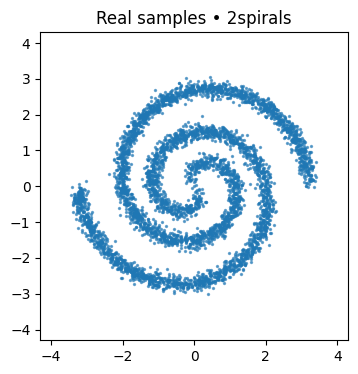

In [3]:
# --- Choose dataset & dataloader ---
data_type = "2spirals"   # "rings" | "8gaussians" | "2spirals" | "checkerboard"
batch_size = 1024
dataset_size = 50000

X_real = generate_data(data_type, batch_size=dataset_size, device="cpu")
ds = TensorDataset(X_real)  # (N,2)
dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True,
                num_workers=0, pin_memory=(device.type=="cuda"))

plt.figure(figsize=(4,4))
sub = X_real[:5000].numpy()
plt.scatter(sub[:,0], sub[:,1], s=2, alpha=0.6)
plt.gca().set_aspect('equal', 'box')
plt.xlim(-4.3,4.3); plt.ylim(-4.3,4.3)
plt.title(f"Real samples • {data_type}")
plt.show()

In [4]:
class MLPGenerator(nn.Module):
    def __init__(self, z_dim=16, hidden=(256,256,256), out_dim=2):
        super().__init__()
        layers = []
        in_dim = z_dim
        for h in hidden:
            layers += [nn.Linear(in_dim, h), nn.ReLU(inplace=True)]
            in_dim = h
        layers += [nn.Linear(in_dim, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, z):
        return self.net(z)

class MLPDiscriminator(nn.Module):
    def __init__(self, in_dim=2, hidden=(256,256,256)):
        super().__init__()
        layers = []
        d = in_dim
        for h in hidden:
            layers += [nn.Linear(d, h), nn.LeakyReLU(0.2, inplace=True)]
            d = h
        layers += [nn.Linear(d, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x).squeeze(-1)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, a=0.2, nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)


def sample_noise(n, z_dim, device):
    return torch.randn(n, z_dim, device=device)

In [5]:
# === Visualization utilities ===
from ipywidgets import IntSlider, Play, jslink, HBox, VBox, HTML, Output
from IPython.display import display
from tqdm import tqdm


def make_grid(xmin=-4.1, xmax=4.1, ymin=-4.1, ymax=4.1, n=140, device="cpu"):
    xs = np.linspace(xmin, xmax, n)
    ys = np.linspace(ymin, ymax, n)
    xx, yy = np.meshgrid(xs, ys)
    grid = np.stack([xx.ravel(), yy.ravel()], axis=1).astype(np.float32)
    grid_t = torch.from_numpy(grid).to(device)
    return xs, ys, grid_t


@torch.no_grad()
def capture_snapshot(G, D, X_real, viz_noise, xs, ys, grid_t, data_type, device, epoch):
    G.eval(); D.eval()
    fake_viz = G(viz_noise).detach().cpu().numpy()
    real_viz = X_real[:len(viz_noise)].detach().cpu().numpy()
    scores   = D(grid_t).view(len(ys), len(xs)).detach().cpu().numpy()
    return {
        "epoch": int(epoch),
        "data_type": data_type,
        "real": real_viz,
        "fake": fake_viz,
        "xs": xs, "ys": ys, "scores": scores,
    }


def init_live_browser():
    import ipywidgets as W
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    out = Output()
    fig, (ax_real, ax_score, ax_fake) = plt.subplots(1, 3, figsize=(15,4))
    fig.subplots_adjust(wspace=0.35)

    cax = inset_axes(ax_score, width="3%", height="90%", loc='right', borderpad=1)

    info   = W.HTML(value="Ready")
    play   = W.Play(interval=400, value=0, min=0, max=0, step=1, description="▶")
    slider = W.IntSlider(value=0, min=0, max=0, step=1,
                         description="epoch idx", continuous_update=True)

    W.link((play, 'value'), (slider, 'value'))

    snapshots = []
    state = {"cbar": None}

    def draw_idx(idx):
        snap = snapshots[idx]
        xs, ys = snap["xs"], snap["ys"]

        ax_real.clear()
        ax_real.set_title(f"Real • {snap['data_type']}")
        ax_real.scatter(snap["real"][:,0], snap["real"][:,1], s=2, alpha=0.6)
        ax_real.set_xlim(-4.1,4.1); ax_real.set_ylim(-4.1,4.1); ax_real.set_aspect('equal','box')

        ax_score.clear()
        ax_score.set_title("Discriminator Score")
        cf = ax_score.contourf(xs, ys, snap["scores"], levels=20, alpha=0.9)
        ax_score.set_xlim(-4.1,4.1); ax_score.set_ylim(-4.1,4.1); ax_score.set_aspect('equal','box')
        if state["cbar"] is None:
            state["cbar"] = fig.colorbar(cf, cax=cax)
        else:
            state["cbar"].update_normal(cf)

        ax_fake.clear()
        ax_fake.set_title(f"Samples @ epoch {snap['epoch']}")
        ax_fake.scatter(snap["fake"][:,0], snap["fake"][:,1], s=2, alpha=0.6)
        ax_fake.set_xlim(-4.1,4.1); ax_fake.set_ylim(-4.1,4.1); ax_fake.set_aspect('equal','box')

        info.value = f"Epoch <b>{snap['epoch']}</b>  |  Snapshots: {len(snapshots)}"
        with out:
            out.clear_output(wait=True)
            display(fig)

    def on_slider(change):
        if change["name"] == "value" and snapshots:
            draw_idx(change["new"])

    slider.observe(on_slider, names="value")

    def push_snapshot(snap):
        snapshots.append(snap)
        new_max = len(snapshots) - 1
        slider.max = new_max
        play.max   = new_max
        play.value = new_max

        if not snapshots:
            with out:
                out.clear_output(wait=True)
                display(fig)

    ui = W.VBox([W.HBox([play, slider, info]), out])
    display(ui)
    return push_snapshot

## Vanilla GAN (Optional, you can play with it if you want)

In [6]:
z_dim = 16
G = MLPGenerator(z_dim=z_dim).to(device)
D = MLPDiscriminator().to(device)
G.apply(weights_init); D.apply(weights_init)

sum_params = lambda m: sum(p.numel() for p in m.parameters())
print(f"G params: {sum_params(G):,} | D params: {sum_params(D):,}")

G params: 136,450 | D params: 132,609


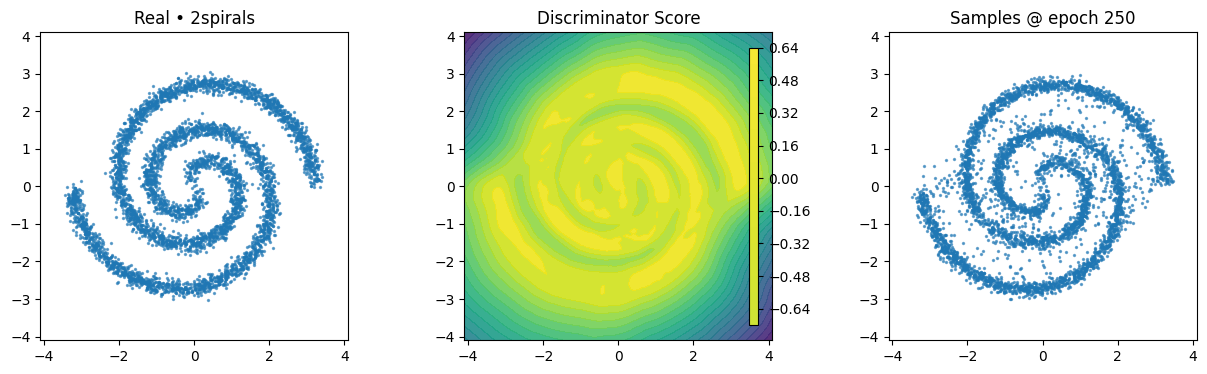

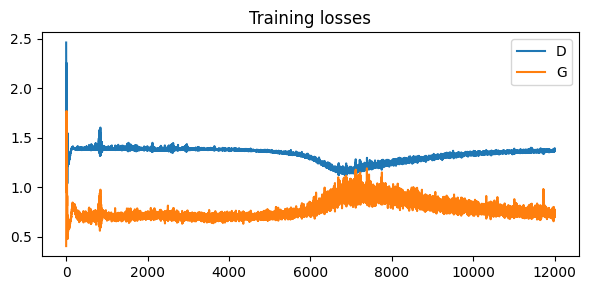

In [7]:
# === Visualization setup ===
VIZ_GRID_N = 140
xs, ys, grid_t = make_grid(n=VIZ_GRID_N, device=device)
viz_noise = torch.randn(5000, z_dim, device=device)
push_snapshot = init_live_browser()

# === Vanilla GAN training ===
lr = 2e-4
beta1, beta2 = 0.5, 0.999
epochs = 250
n_critic = 1

opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
bce_logits = nn.BCEWithLogitsLoss()

g_losses, d_losses = [], []

for epoch in range(1, epochs+1):
    G.train(); D.train()
    pbar = tqdm(dl, desc=f"[Epoch {epoch}/{epochs}]", leave=False)
    for real_batch, in pbar:
        real = real_batch.to(device, non_blocking=True)     # (B,2)
        B = real.size(0)

        # ===== 1) Update Discriminator =====
        for _ in range(n_critic):
            z = torch.randn(B, z_dim, device=device)
            with torch.no_grad():
                fake_detached = G(z)                        # (B,2)
            D_real = D(real)                                # logits
            D_fake = D(fake_detached)
            d_loss = bce_logits(D_real, torch.ones_like(D_real)) + \
                     bce_logits(D_fake, torch.zeros_like(D_fake))
            opt_D.zero_grad(set_to_none=True)
            d_loss.backward()
            opt_D.step()

        # ===== 2) Update Generator (non-saturating) =====
        z = torch.randn(B, z_dim, device=device)
        fake = G(z)
        D_fake_for_G = D(fake)
        g_loss = bce_logits(D_fake_for_G, torch.ones_like(D_fake_for_G))
        opt_G.zero_grad(set_to_none=True)
        g_loss.backward()
        opt_G.step()

        g_losses.append(g_loss.item()); d_losses.append(d_loss.item())
        pbar.set_postfix(d=f"{d_loss.item():.3f}", g=f"{g_loss.item():.3f}")

    if epoch % 10 == 0 or epoch == epochs:
        snap = capture_snapshot(G, D, X_real, viz_noise, xs, ys, grid_t, data_type, device, epoch)
        push_snapshot(snap)

plt.figure(figsize=(6,3))
plt.plot(d_losses, label="D"); plt.plot(g_losses, label="G")
plt.legend(); plt.title("Training losses"); plt.tight_layout(); plt.show()

## WGAN-GP

In [8]:
z_dim = 16
G = MLPGenerator(z_dim=z_dim).to(device)
D = MLPDiscriminator().to(device)
G.apply(weights_init); D.apply(weights_init)

sum_params = lambda m: sum(p.numel() for p in m.parameters())
print(f"G params: {sum_params(G):,} | D params: {sum_params(D):,}")

G params: 136,450 | D params: 132,609


### 🧩 Task: Implement the one-sided **variance** Gradient Penalty

👉 In your function `gradient_penalty`,
replace the standard GP with the “variance” version from *Remark 2*, which penalizes only when  

$$
|\nabla_{\hat x} D(\hat x)|^2 > 1
$$



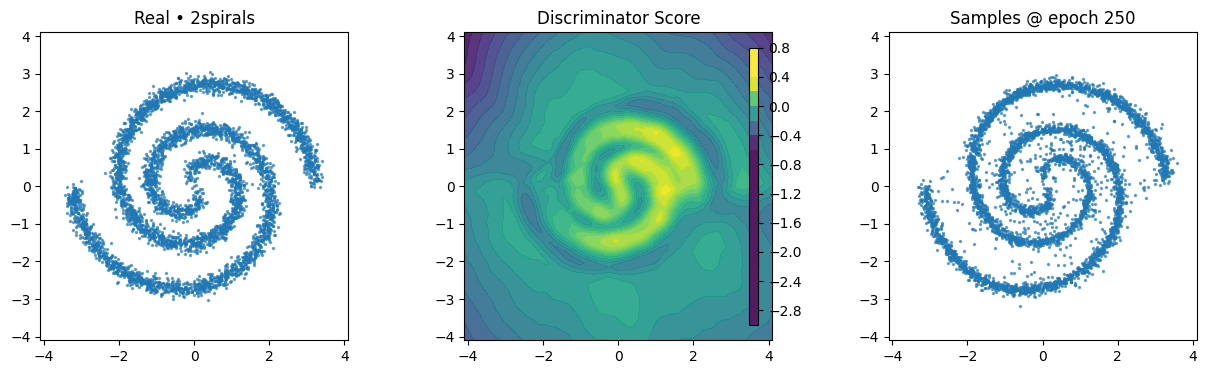

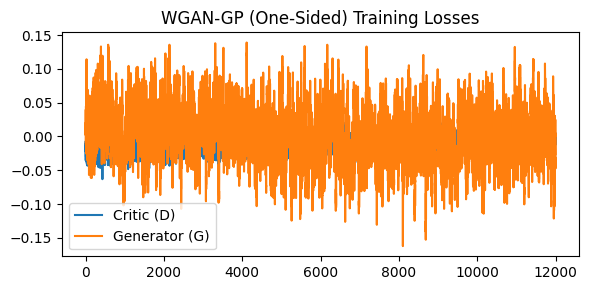

In [13]:
# --- Visualization setup ---
VIZ_GRID_N = 140
xs, ys, grid_t = make_grid(n=VIZ_GRID_N, device=device)
viz_noise = torch.randn(5000, z_dim, device=device)
push_snapshot = init_live_browser()

# --- WGAN-GP settings ---
lr_G, lr_D = 1e-4, 1e-4
beta1, beta2 = 0.0, 0.9
epochs = 250
n_critic = 2
gp_lambda = 1.0

one_side_gp = True

opt_G = torch.optim.Adam(G.parameters(), lr=lr_G, betas=(beta1, beta2))
opt_D = torch.optim.Adam(D.parameters(), lr=lr_D, betas=(beta1, beta2))

# --- WGAN-GP gradient penalty ---
def gradient_penalty(D, real, fake, one_side=True, return_norm=False):
    B = real.size(0)
    mixing = torch.rand(B, *([1] * (real.dim() - 1)), device=real.device)
    x_hat = mixing * real + (1.0 - mixing) * fake
    x_hat.requires_grad_(True)

    d_hat = D(x_hat)
    grad_outputs = torch.ones_like(d_hat, device=x_hat.device)

    grads = torch.autograd.grad(
        outputs=d_hat,
        inputs=x_hat,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Flatten to compute norm per sample
    gn = grads.flatten(1).norm(2, dim=1)

    # One-Sided Gradient Penalty variant
    if one_side:
        gp = torch.mean(torch.relu(gn - 1) ** 2)
    else:
        gp = torch.mean((gn - 1) ** 2)

    return (gp, gn.mean()) if return_norm else gp


g_losses, d_losses = [], []

for epoch in range(1, epochs + 1):
    G.train(); D.train()
    pbar = tqdm(dl, desc=f"[Epoch {epoch}/{epochs}]", leave=False)

    for real_batch, in pbar:
        real = real_batch.to(device, non_blocking=True)  # (B, 2)
        B = real.size(0)

        # ===== 1) Update Critic n_critic times =====
        for _ in range(n_critic):
            z = torch.randn(B, z_dim, device=device)
            with torch.no_grad():
                fake_detached = G(z)

            D_real = D(real).view(-1)
            D_fake = D(fake_detached).view(-1)

            # Compute gradient penalty
            gp, gn_mean = gradient_penalty(
                D, real, fake_detached,
                one_side=one_side_gp,
                return_norm=True
            )

            # Critic loss (includes One-Sided GP)
            loss_D = -(torch.mean(D_real) - torch.mean(D_fake)) + gp_lambda * gp

            # Small drift term for stability
            drift = 0.001 * (D_real.pow(2).mean())
            loss_D += drift

            opt_D.zero_grad(set_to_none=True)
            loss_D.backward()
            opt_D.step()

        # ===== 2) Update Generator =====
        z = torch.randn(B, z_dim, device=device)
        fake = G(z)
        loss_G = -D(fake).view(-1).mean()

        opt_G.zero_grad(set_to_none=True)
        loss_G.backward()
        opt_G.step()

        # Record losses
        g_losses.append(loss_G.item())
        d_losses.append(loss_D.item())

        # Progress bar
        pbar.set_postfix(
            d=f"{loss_D.item():.3f}",
            g=f"{loss_G.item():.3f}",
            gp=f"{gp.item():.3f}",
            gn=f"{gn_mean.item():.2f}",
        )

    # Visualization every few epochs
    if epoch % 10 == 0 or epoch == epochs:
        snap = capture_snapshot(G, D, X_real, viz_noise, xs, ys, grid_t, data_type, device, epoch)
        push_snapshot(snap)

# ================================================================
# Plot Training Curves
# ================================================================
plt.figure(figsize=(6, 3))
plt.plot(d_losses, label="Critic (D)")
plt.plot(g_losses, label="Generator (G)")
plt.legend()
plt.title("WGAN-GP (One-Sided) Training Losses")
plt.tight_layout()
plt.show()

